# Simulación de matriz user-ítem

In [66]:
import numpy as np

def generate_mask_zipf_global(
    U: int,
    I: int,
    density: float = 0.01,
    alpha_user: float = 1.1,
    alpha_item: float = 1.2,
    seed: int = 0,
    oversample: float = 1.5,
    min_user_ratings: int | None = None,
    min_item_ratings: int | None = None,
):
    """
    Generates ~M unique (u,i) pairs with long-tailed user and item marginals,
    WITHOUT looping over users (for the main sampling).

    - Users: Zipf(alpha_user) then permuted across IDs
    - Items: Zipf(alpha_item) then permuted across IDs
    - Global sampling + dedup to enforce uniqueness of (u,i)

    Optional:
      - min_user_ratings: ensure each user has at least this many interactions
      - min_item_ratings: ensure each item has at least this many interactions

    Note: enforcing minima may increase the final number of pairs beyond M.
    """
    if U <= 0 or I <= 0:
        return []

    if min_user_ratings is not None and min_user_ratings < 0:
        raise ValueError("min_user_ratings must be >= 0 or None.")
    if min_item_ratings is not None and min_item_ratings < 0:
        raise ValueError("min_item_ratings must be >= 0 or None.")
    if min_user_ratings is not None and min_user_ratings > I:
        raise ValueError("min_user_ratings cannot exceed I (unique items per user).")
    if min_item_ratings is not None and min_item_ratings > U:
        raise ValueError("min_item_ratings cannot exceed U (unique users per item).")

    rng = np.random.default_rng(seed)
    M = int(round(density * U * I))
    M = max(0, min(M, U * I))
    if M == 0 and (min_user_ratings is None and min_item_ratings is None):
        return []

    # User probs (Zipf by rank) + permute IDs
    ru = np.arange(1, U + 1, dtype=np.float64)
    pu = ru ** (-alpha_user)
    pu /= pu.sum()
    pu = pu[rng.permutation(U)]

    # Item probs (Zipf by rank) + permute IDs
    ri = np.arange(1, I + 1, dtype=np.float64)
    pi = ri ** (-alpha_item)
    pi /= pi.sum()
    pi = pi[rng.permutation(I)]

    # Collect unique (u,i) pairs via integer keys
    keys = np.empty(0, dtype=np.int64)

    while keys.size < M:
        need = M - keys.size
        batch = int(np.ceil(need * oversample)) + 32

        u = rng.choice(U, size=batch, replace=True, p=pu).astype(np.int64)
        i = rng.choice(I, size=batch, replace=True, p=pi).astype(np.int64)

        k = u * np.int64(I) + i
        keys = np.unique(np.concatenate([keys, k]))

        if keys.size == U * I:
            break

    keys = keys[:M]

    # ---- Enforce minima (may add extra pairs) ----
    if min_user_ratings is not None or min_item_ratings is not None:
        key_set = set(keys.tolist())

        # current degrees
        u0 = (keys // I).astype(np.int64)
        i0 = (keys % I).astype(np.int64)
        user_deg = np.bincount(u0, minlength=U).astype(np.int64)
        item_deg = np.bincount(i0, minlength=I).astype(np.int64)

        def add_pair(uu: int, ii: int):
            kk = int(uu) * int(I) + int(ii)
            if kk in key_set:
                return False
            key_set.add(kk)
            user_deg[uu] += 1
            item_deg[ii] += 1
            return True

        # 1) ensure min per user
        if min_user_ratings is not None:
            for uu in np.where(user_deg < min_user_ratings)[0]:
                need_u = int(min_user_ratings - user_deg[uu])
                tries = 0
                while need_u > 0 and len(key_set) < U * I and tries < 10_000:
                    batch = int(np.ceil(need_u * oversample)) + 32
                    cand_items = rng.choice(I, size=batch, replace=True, p=pi).astype(np.int64)
                    cand_items = np.unique(cand_items)

                    added = 0
                    for ii in cand_items:
                        if add_pair(int(uu), int(ii)):
                            added += 1
                            need_u -= 1
                            if need_u == 0:
                                break
                    if added == 0:
                        tries += 1
                    else:
                        tries = 0  # reset if we made progress

        # 2) ensure min per item
        if min_item_ratings is not None:
            for ii in np.where(item_deg < min_item_ratings)[0]:
                need_i = int(min_item_ratings - item_deg[ii])
                tries = 0
                while need_i > 0 and len(key_set) < U * I and tries < 10_000:
                    batch = int(np.ceil(need_i * oversample)) + 32
                    cand_users = rng.choice(U, size=batch, replace=True, p=pu).astype(np.int64)
                    cand_users = np.unique(cand_users)

                    added = 0
                    for uu in cand_users:
                        if add_pair(int(uu), int(ii)):
                            added += 1
                            need_i -= 1
                            if need_i == 0:
                                break
                    if added == 0:
                        tries += 1
                    else:
                        tries = 0

        # back to arrays
        keys = np.fromiter(key_set, dtype=np.int64)

    u = (keys // I).astype(int)
    i = (keys % I).astype(int)
    return list(zip(u.tolist(), i.tolist()))


In [50]:

def tail_stats(pairs, U, I, top_frac=0.1):
    pairs = np.asarray(pairs, dtype=np.int64)
    u = pairs[:, 0]
    i = pairs[:, 1]

    density = len(pairs) / (U * I)

    user_deg = np.bincount(u, minlength=U)
    item_deg = np.bincount(i, minlength=I)

    def top_share(deg):
        k = max(1, int(round(top_frac * len(deg))))
        return deg[np.argsort(deg)[-k:]].sum() / max(1, deg.sum())

    return {
        "density": density,
        "users_zero": int((user_deg == 0).sum()),
        "items_zero": int((item_deg == 0).sum()),
        f"top{int(top_frac*100)}%_users_share": float(top_share(user_deg)),
        f"top{int(top_frac*100)}%_items_share": float(top_share(item_deg)),
        "max_user_deg": int(user_deg.max()),
        "max_item_deg": int(item_deg.max()),
    }


In [96]:
U, I = 1000, 2000
pairs = generate_mask_zipf_global(U, I, density=0.05, alpha_user=0.9, alpha_item=0.6, seed=42, min_user_ratings=20, min_item_ratings=5)

stats = tail_stats(pairs, U, I, top_frac=0.10)
print(stats)


{'density': 0.0503265, 'users_zero': 0, 'items_zero': 0, 'top10%_users_share': 0.47128252511102503, 'top10%_items_share': 0.29094016075030055, 'max_user_deg': 1960, 'max_item_deg': 679}


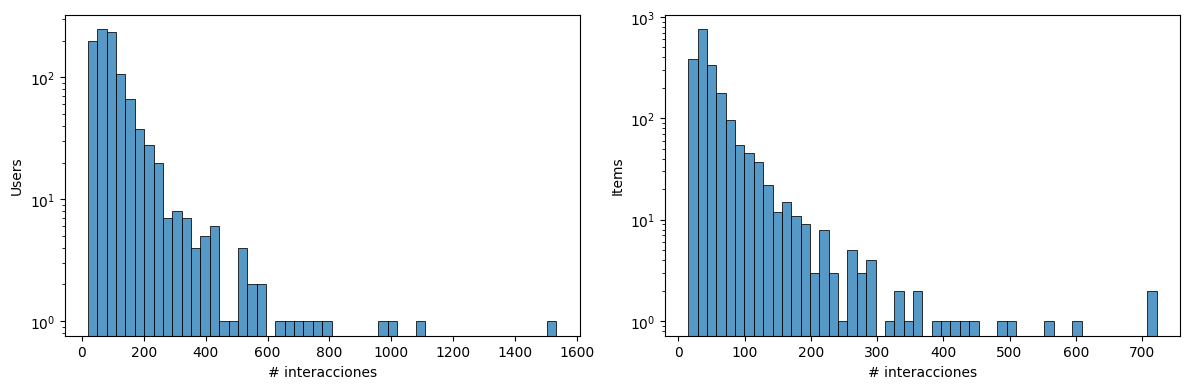

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

pairs_arr = np.asarray(pairs)
user_deg = np.bincount(pairs_arr[:, 0], minlength=U)
item_deg = np.bincount(pairs_arr[:, 1], minlength=I)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(user_deg, bins=50, ax=axes[0])
axes[0].set_xlabel("# interacciones")   
axes[0].set_ylabel("Users")
axes[0].set_yscale("log")   # key for long tail

sns.histplot(item_deg, bins=50, ax=axes[1])
axes[1].set_xlabel("# interacciones")
axes[1].set_ylabel("Items")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()
